In [1]:
! pip install pandas matplotlib torch torchvision

In [2]:
import os, sys

# GLobal Constants

In [3]:
DATASET_DIR = f"..{os.sep}dataset{os.sep}IIIT-CFW1.0"
CARTOON_DATASET = "cartoonFaces"
REAL_FACES = "realFaces"
DATASET_FILE = "dataset.csv"

RANDOM_STATE = 1

# Load the Dataset

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

root_dir = os.path.abspath(os.path.join('..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from src.dataset import RealCartoon

datasets = {
    phase: RealCartoon(
        csv_file=f"{DATASET_DIR}{os.sep}{DATASET_FILE}",
        set_type=phase,
        root_dir='./',
        transforms=transforms.Compose([
            transforms.Resize((224,224)),
            # transforms.RandomHorizontalFlip(p=0.25),
            # transforms.RandomVerticalFlip(p=0.25),
            # # transforms.ColorJitter(brightness=(0.8,1), contrast=(0.8,1)),
            # # transforms.RandomPerspective(),
            # transforms.RandomRotation(degrees=(0, 60)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    for phase in ['train', 'test', 'val']
}

dataloaders = {
    phase: DataLoader(
        datasets[phase], 
        batch_size=64,
        shuffle=True, 
        num_workers=8
        )
    for phase in ['train', 'test', 'val']
}

# Plot Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


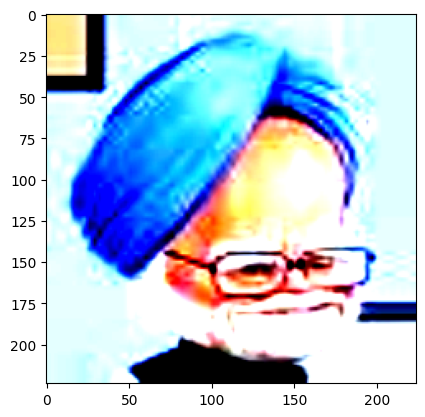

In [5]:
import random
import matplotlib.pyplot as plt

image_index = random.randint(0,len(datasets['test']))

plt.imshow(datasets['test'][image_index][0].permute(1, 2, 0)  )


# Load Pre-Trained Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


import time
import os
import copy

In [7]:
epochs = 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# efficientnet_b7 = models.efficientnet_b7(progress=True, pretrained=True)
# efficientnet_b7([val_dataset[2][0], val_dataset[0][0]])

In [9]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in your custom dataset
model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)

# build optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


print(f"Training on {device}")

for epoch in range(epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    for images, labels in dataloaders['train']:
        if images.shape[1] == 1:
            continue
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloaders['test'])
    accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

/home/mutakabbir/Projects/real-cartoon/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mutakabbir/Projects/real-cartoon/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on cuda:0
Epoch [1/9], Loss: 0.0000, Accuracy: 5658.06%
Epoch [2/9], Loss: 0.0000, Accuracy: 5664.52%
Epoch [3/9], Loss: 0.0000, Accuracy: 5654.84%
Epoch [4/9], Loss: 0.0000, Accuracy: 5661.29%
Epoch [5/9], Loss: 0.0000, Accuracy: 5661.29%
Epoch [6/9], Loss: 0.0000, Accuracy: 5658.06%
Epoch [7/9], Loss: 0.0000, Accuracy: 5664.52%
Epoch [8/9], Loss: 0.0000, Accuracy: 5667.74%
Epoch [9/9], Loss: 0.0000, Accuracy: 5680.65%
